# PDG ATTACK 

### *Import*

In [1]:
import numpy as np
import torch
from torch.nn import CrossEntropyLoss
from PIL import Image
from torchvision import transforms
from art.attacks.evasion import ProjectedGradientDescentPyTorch
from art.estimators.classification import PyTorchClassifier
import matplotlib.pyplot as plt
import tensorflow as tf

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

/Users/danieleabbagnale/Desktop/AI CyberSecurity/Face_Recognition_Security/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/danieleabbagnale/Desktop/AI CyberSecurity/Face_Recognition_Security/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


cpu


### initialization


In [2]:
if str(device) in 'cuda':
    print("Import Inception.Inception")
    import inception
    nn1 = inception.InceptionResnetV1(pretrained='vggface2').eval()
elif str(device) == "cpu":
    print("Import Facenet.Inception")
    from facenet_pytorch import InceptionResnetV1
    nn1 = InceptionResnetV1(pretrained='vggface2').eval()

Import Facenet.Inception


In [3]:
from utils import get_labels


nn1.classify = True
nn1.to(device)
LABELS = get_labels()

In [4]:

from torch.nn import CrossEntropyLoss
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import ProjectedGradientDescentPyTorch


#Impostare l'input shape
model_nn1 = PyTorchClassifier(nn1,input_shape=[224,224], loss=CrossEntropyLoss(),nb_classes=8631, device_type=device) #This class implements a classifier with the PyTorch framework.


In [5]:
from RESNET import ResNet
from utils import get_labels
from utils import load_state_dict

nn2 = ResNet.resnet50(num_classes=8631, include_top=True)


load_state_dict(nn2,'resnet50_scratch_weight.pkl')
nn2.eval()

model_nn2 = PyTorchClassifier(nn2,input_shape=[224,224], loss=CrossEntropyLoss(),nb_classes=8631, device_type=device)

LABELS = get_labels()

### Untargeted Attack on all test set

In [6]:
# PGD generic Attack for all samples
import os
import re
from utils import load_image_NN1, load_test_image_NN2

dataset_dir = "test_set_cropped/" 
eps_step = [0.000001, 0.00001, 0.0001, 0.0003, 0.0005, 0.0007, 0.001, 0.005, 0.007, 0.01] #La dimensione del passo della variazione dell'input a ogni iterazione. Questo parametro definisce quanto grande sarà ogni passo nella direzione del gradiente. #La dimensione del passo della variazione dell'input per il calcolo della perturbazione minima. Questo parametro è utilizzato quando minimal è impostato su True.
max_iter = [2,5,7]  # Il numero massimo di iterazioni. Questo parametro determina quante volte l'attacco iterativo sarà eseguito.
 
eps_range = 0.03 #Questo valore determina l'ampiezza massima della perturbazione aggiunta agli input originali. Può essere un valore singolo (int o float) o un array numpy (ndarray).

accuracy_for_eps_nn1 = np.zeros((len(max_iter),len(eps_step)))
perturbation_for_eps_nn1 = np.zeros((len(max_iter),len(eps_step)))
correct_predictions_nn1 = 0

accuracy_for_eps_nn2 = np.zeros((len(max_iter),len(eps_step)))
perturbation_for_eps_nn2 = np.zeros((len(max_iter),len(eps_step)))
correct_predictions_nn2 = 0

total_images = 0
print("Inizio Attacco PGD UNTARGETED")
for i in range(len(max_iter)):
        print("**** Attacco con max_iter {} **** ".format(max_iter[i]))
        for j in range(len(eps_step)):   #Se qualcosa funziona strano controllare questo zip
            correct_predictions_nn1 = 0
            correct_predictions_nn2 = 0
            total_images = 0
            perturbation = []
            
            attack = ProjectedGradientDescentPyTorch(estimator=model_nn1, eps = eps_range, eps_step=eps_step[j], targeted=False, max_iter = max_iter[i])
            
            print("**** Attacco con eps:{} con step a {} ****".format(eps_range,eps_step[j]))
            for filename in os.listdir(dataset_dir):
                if filename.endswith(".jpg") or filename.endswith(".jpeg"):
                    person_path = os.path.join(dataset_dir, filename)
                    test_img = load_image_NN1(person_path,device)
                    test_img = test_img.numpy()
                    test_images_adv = attack.generate(test_img)
                    nn1_predictions = model_nn1.predict(test_images_adv)

                    test_images_NN2 = load_test_image_NN2(test_images_adv)


                    nn2_predictions = model_nn2.predict(test_images_NN2)

                    correct_label = re.sub(r'_\d+_face_0\.jpg$', '', filename)
                    #print("Etichetta corretta:", correct_label)   
                    perturbation.append(np.mean(np.abs((test_images_adv - test_img))))  #Salvo le perturbazioni applicate su ogni immagine
            
                    predicted_label_nn1 = LABELS[np.array(nn1_predictions.argmax())]
                    predicted_label_nn2 = LABELS[np.array(nn2_predictions.argmax())]
                    #print("Predetto {} con probabilità {} e con perturbazione {}".format(predicted_label,model_predictions[0][model_predictions.argmax()],perturbation[-1]))
                    total_images+=1
                    
                    predicted_label_nn1 = str(predicted_label_nn1)  # da togliere ?

                    
                    if correct_label in predicted_label_nn1:
                        correct_predictions_nn1+=1

                    #print("Adversarial Sample misclassificati correttamente attuale: {}%".format((100-(accuracy*100))))
                    accuracy_nn1 = correct_predictions_nn1/total_images

                    if correct_label in predicted_label_nn2:
                        correct_predictions_nn2+=1

                    accuracy_nn2 = correct_predictions_nn2/total_images    

                    
            

            if total_images != 0:    #Per ogni epsilon impostata salvo in accuracy plot
                if len(perturbation) == total_images:
                    perturbazione_media = sum(perturbation)/total_images    #Calcolo la media delle perturbazioni applicate su tutte le immagini per una determinata epsilon
                    perturbation_for_eps_nn1[i][j] = perturbazione_media
                    #print("----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: {} equivale a {}% ----------------".format(eps_step[j],perturbazione_media))


                final_accuracy_nn1 = correct_predictions_nn1/total_images
                accuracy_for_eps_nn1[i][j] = final_accuracy_nn1

                final_accuracy_nn2 = correct_predictions_nn2/total_images
                accuracy_for_eps_nn2[i][j] = final_accuracy_nn2
                #print("----------- Accuracy sugli adversarial Sample per eps_step: {} equivale a {}% ----------------".format(eps_step[j],final_accuracy))
                #print("")
            #Per ogni epsilon impostata salvo in accuracy plot
       #print("--------------------------------------------------------------------------------------------------------------------------------------------------------------------")
       #print()


Inizio Attacco PGD UNTARGETED
**** Attacco con max_iter 2 **** 
**** Attacco con eps:0.03 con step a 1e-06 ****


**** Attacco con eps:0.03 con step a 1e-05 ****


**** Attacco con eps:0.03 con step a 0.0001 ****


**** Attacco con eps:0.03 con step a 0.0003 ****


**** Attacco con eps:0.03 con step a 0.0005 ****


**** Attacco con eps:0.03 con step a 0.0007 ****


**** Attacco con eps:0.03 con step a 0.001 ****


**** Attacco con eps:0.03 con step a 0.005 ****


**** Attacco con eps:0.03 con step a 0.007 ****


**** Attacco con eps:0.03 con step a 0.01 ****


**** Attacco con max_iter 5 **** 
**** Attacco con eps:0.03 con step a 1e-06 ****


**** Attacco con eps:0.03 con step a 1e-05 ****


**** Attacco con eps:0.03 con step a 0.0001 ****


**** Attacco con eps:0.03 con step a 0.0003 ****


**** Attacco con eps:0.03 con step a 0.0005 ****


**** Attacco con eps:0.03 con step a 0.0007 ****


**** Attacco con eps:0.03 con step a 0.001 ****


**** Attacco con eps:0.03 con step a 0.005 ****


**** Attacco con eps:0.03 con step a 0.007 ****


**** Attacco con eps:0.03 con step a 0.01 ****


**** Attacco con max_iter 7 **** 
**** Attacco con eps:0.03 con step a 1e-06 ****


**** Attacco con eps:0.03 con step a 1e-05 ****


**** Attacco con eps:0.03 con step a 0.0001 ****


**** Attacco con eps:0.03 con step a 0.0003 ****


**** Attacco con eps:0.03 con step a 0.0005 ****


**** Attacco con eps:0.03 con step a 0.0007 ****


**** Attacco con eps:0.03 con step a 0.001 ****


**** Attacco con eps:0.03 con step a 0.005 ****


**** Attacco con eps:0.03 con step a 0.007 ****


**** Attacco con eps:0.03 con step a 0.01 ****


### Plot results

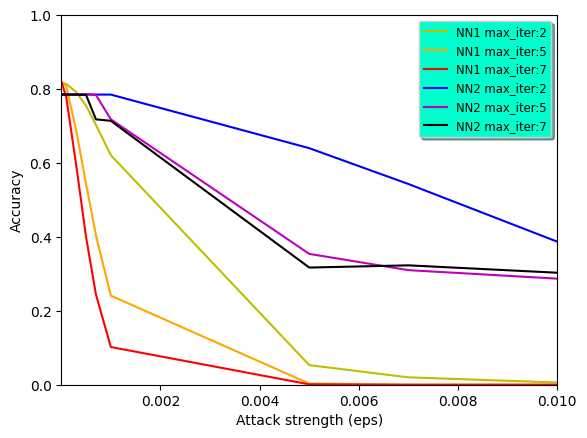

In [27]:
from matplotlib import pyplot as plt

# plot accuracy/Attack strength


fig, ax = plt.subplots()


ax.plot(np.array(eps_step), np.array(accuracy_for_eps_nn1[0]), 'y-', label='NN1 max_iter:{}'.format(max_iter[0]))
ax.plot(np.array(eps_step), np.array(accuracy_for_eps_nn1[1]), 'orange', label='NN1 max_iter:{}'.format(max_iter[1]))
ax.plot(np.array(eps_step), np.array(accuracy_for_eps_nn1[2]), 'red', label='NN1 max_iter:{}'.format(max_iter[2]))


ax.plot(np.array(eps_step), np.array(accuracy_for_eps_nn2[0]), 'b-', label='NN2 max_iter:{}'.format(max_iter[0]))
ax.plot(np.array(eps_step), np.array(accuracy_for_eps_nn2[1]), 'm-', label='NN2 max_iter:{}'.format(max_iter[1]))
ax.plot(np.array(eps_step), np.array(accuracy_for_eps_nn2[2]), 'black', label='NN2 max_iter:{}'.format(max_iter[2]))




legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')

# Impostazione delle scale sugli assi x e y
ax.set_xlim(eps_step[0], eps_step[-1])  # Imposta i limiti dell'asse x
ax.set_ylim(0,1)  # Imposta i limiti dell'asse y

plt.xlabel('Attack strength (eps)')
plt.ylabel('Accuracy')
plt.show()

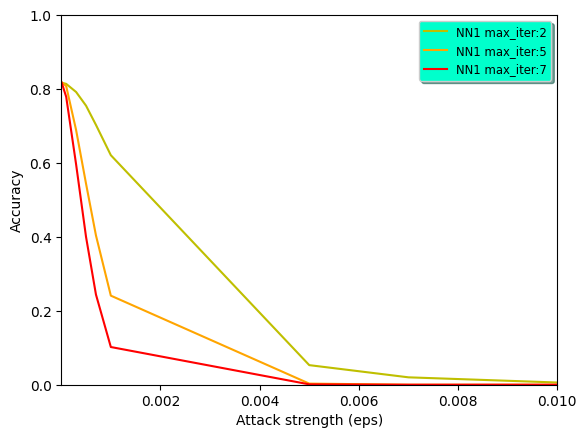

In [12]:
from matplotlib import pyplot as plt

# plot accuracy/Attack strength

fig, ax = plt.subplots()
ax.plot(np.array(eps_step), np.array(accuracy_for_eps_nn1[0]), 'y-', label='NN1 max_iter:{}'.format(max_iter[0]))
ax.plot(np.array(eps_step), np.array(accuracy_for_eps_nn1[1]), 'orange', label='NN1 max_iter:{}'.format(max_iter[1]))
ax.plot(np.array(eps_step), np.array(accuracy_for_eps_nn1[2]), 'red', label='NN1 max_iter:{}'.format(max_iter[2]))

legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')

# Impostazione delle scale sugli assi x e y
ax.set_xlim(eps_step[0], eps_step[-1])  # Imposta i limiti dell'asse x
ax.set_ylim(0,1)  # Imposta i limiti dell'asse y

plt.xlabel('Attack strength (eps)')
plt.ylabel('Accuracy')
plt.show()

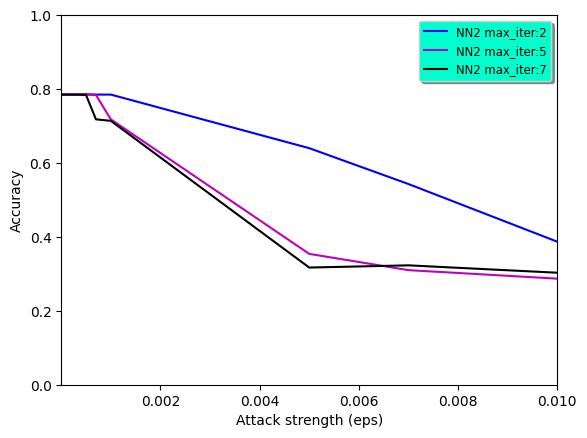

In [24]:
from matplotlib import pyplot as plt

# plot accuracy/Attack strength

fig, ax = plt.subplots()
ax.plot(np.array(eps_step), np.array(accuracy_for_eps_nn2[0]), 'b-', label='NN2 max_iter:{}'.format(max_iter[0]))
ax.plot(np.array(eps_step), np.array(accuracy_for_eps_nn2[1]), 'm-', label='NN2 max_iter:{}'.format(max_iter[1]))
ax.plot(np.array(eps_step), np.array(accuracy_for_eps_nn2[2]), 'black', label='NN2 max_iter:{}'.format(max_iter[2]))

legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')

# Impostazione delle scale sugli assi x e y
ax.set_xlim(eps_step[0], eps_step[-1])  # Imposta i limiti dell'asse x
ax.set_ylim(0,1)  # Imposta i limiti dell'asse y

plt.xlabel('Attack strength (eps)')
plt.ylabel('Accuracy')
plt.show()



In [18]:
print(eps_step)
print(accuracy_for_eps_nn1)
print(accuracy_for_eps_nn2)

[1e-06, 1e-05, 0.0001, 0.0003, 0.0005, 0.0007, 0.001, 0.005, 0.007, 0.01]
[[0.819 0.817 0.814 0.792 0.755 0.703 0.621 0.053 0.02  0.006]
 [0.819 0.818 0.808 0.689 0.544 0.404 0.241 0.003 0.    0.   ]
 [0.819 0.817 0.779 0.596 0.4   0.244 0.102 0.001 0.    0.   ]]
[[0.785 0.785 0.785 0.785 0.786 0.785 0.785 0.64  0.543 0.387]
 [0.785 0.785 0.785 0.785 0.785 0.784 0.718 0.354 0.31  0.287]
 [0.785 0.785 0.785 0.785 0.784 0.718 0.714 0.317 0.323 0.303]]


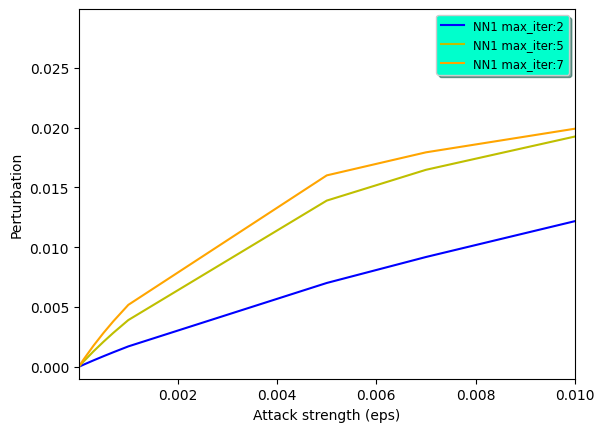

In [28]:
from matplotlib import pyplot as plt

# plot accuracy/Attack strength

fig, ax = plt.subplots()
ax.plot(np.array(eps_step), np.array(perturbation_for_eps_nn1[0]), 'b-', label='NN1 max_iter:{}'.format(max_iter[0]))


ax.plot(np.array(eps_step), np.array(perturbation_for_eps_nn1[1]), 'y-', label='NN1 max_iter:{}'.format(max_iter[1]))


ax.plot(np.array(eps_step), np.array(perturbation_for_eps_nn1[2]), 'orange', label='NN1 max_iter:{}'.format(max_iter[2]))

legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')

# Impostazione delle scale sugli assi x e y
ax.set_xlim(eps_step[0], eps_step[-1])  # Imposta i limiti dell'asse x
ax.set_ylim(perturbation_for_eps_nn1[2][0]-0.001,perturbation_for_eps_nn1[2][-1]+0.01)  # Imposta i limiti dell'asse y

plt.xlabel('Attack strength (eps)')
plt.ylabel('Perturbation')
plt.show()




### Single sample Untargeted attack

In [ ]:
epsilon = 0.01
eps_step = 0.05
max_iter = 3 

attack = ProjectedGradientDescentPyTorch(estimator=model_nn1, eps = epsilon, eps_step= eps_step, targeted=False, max_iter = max_iter)

In [ ]:
from utils import load_image_NN1, load_test_image_NN2
import os
import numpy as np



dataset_dir = "test_set_cropped_piccolo/"
filename = "Brad_Pitt_1_face_0.jpg"
person_path = os.path.join(dataset_dir, filename)

test_img = load_image_NN1(person_path,device)
test_img_numpy = test_img.numpy()
test_images_adv = attack.generate(test_img_numpy)


nn1_predictions = model_nn1.predict(test_images_adv)
perturbation = np.mean(np.abs((test_images_adv - test_img_numpy)))
print('Average perturbation: {:4.2f}'.format(perturbation))


test_images_NN2 = load_test_image_NN2(test_images_adv)


nn2_predictions = model_nn2.predict(test_images_NN2)


predicted_label_nn1 = LABELS[np.array(nn1_predictions.argmax())]
predicted_label_nn2 = LABELS[np.array(nn2_predictions.argmax())]
print("NN1{} con probabilità {}".format(predicted_label_nn1,nn1_predictions[0][nn1_predictions.argmax()]))
print("NN2{} con probabilità {}".format(predicted_label_nn2,nn2_predictions[0][nn2_predictions.argmax()]))


In [ ]:
# Prepara le immagini per la visualizzazione
# Rimuovi la dimensione batch extra e converti nel formato channels-last
test_images_adv = np.squeeze(test_images_adv, axis=0)
test_images_adv = np.transpose(test_images_adv, (1, 2, 0))

# Converti le immagini in uint8 per la visualizzazione
if test_img_numpy.dtype != np.uint8:
    test_img_numpy = (test_img_numpy * 255).astype(np.uint8)
    test_img_numpy = np.squeeze(test_img_numpy, axis=0)  # Rimuovi la dimensione batch extra
    test_img_numpy = np.transpose(test_img_numpy, (1, 2, 0))

if test_images_adv.dtype != np.uint8:
    test_images_adv = (test_images_adv * 255).astype(np.uint8)

# Visualizza le immagini affiancate con Matplotlib
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Mostra l'immagine originale
ax1.imshow(test_img_numpy)
ax1.set_title('Original Image')
ax1.axis('off')

# Mostra l'immagine avversaria
ax2.imshow(test_images_adv)
ax2.set_title(f'Adversarial Image\nPredicted: {predicted_label_nn1}')
ax2.axis('off')

# Mostra la figura
plt.suptitle("DeepFool Adversarial Images")
plt.show()


### Targeted Attack on all test set

In [ ]:
import os
import re
from utils import load_image_NN1, load_test_image_NN2

dataset_dir = "test_set_cropped/" 
eps_step = [0.00001, 0.0001, 0.001, 0.003, 0.005, 0.007, 0.01, 0.05, 0.07, 0.1] #La dimensione del passo della variazione dell'input a ogni iterazione. Questo parametro definisce quanto grande sarà ogni passo nella direzione del gradiente. #La dimensione del passo della variazione dell'input per il calcolo della perturbazione minima. Questo parametro è utilizzato quando minimal è impostato su True.

max_iter = [2,5,7]  # Il numero massimo di iterazioni. Questo parametro determina quante volte l'attacco iterativo sarà eseguito.
 
eps_range = 0.03 #Questo valore determina l'ampiezza massima della perturbazione aggiunta agli input originali. Può essere un valore singolo (int o float) o un array numpy (ndarray).

accuracy_for_eps_nn1 = np.zeros((len(max_iter),len(eps_step)))
perturbation_for_eps_nn1 = np.zeros((len(max_iter),len(eps_step)))
correct_predictions_nn1 = 0
accuracy_misclassified_for_eps_nn1 = np.zeros((len(max_iter),len(eps_step)))
correct_misclassified_nn1 = 0

accuracy_for_eps_nn2 = np.zeros((len(max_iter),len(eps_step)))
perturbation_for_eps_nn2 = np.zeros((len(max_iter),len(eps_step)))
correct_predictions_nn2 = 0
accuracy_misclassified_for_eps_nn2 = np.zeros((len(max_iter),len(eps_step)))
correct_misclassified_nn2 = 0

total_images = 0

target_class = 10
etichetta_target = LABELS[10]
print("ETICHETTA TARGET: ", LABELS[10])
shape = 1 #shape di test image 
batch_size = shape
targeted_labels = np.array([target_class] * batch_size)
one_hot_targeted_labels = tf.keras.utils.to_categorical(targeted_labels, num_classes=8631)



print("Inizio Attacco PGD TARGETED")
for i in range(len(max_iter)):
        print("**** Attacco con max_iter {} **** ".format(max_iter[i]))
        for j in range(len(eps_step)):   #Se qualcosa funziona strano controllare questo zip
            correct_predictions_nn1 = 0
            correct_predictions_nn2 = 0
            correct_misclassified_nn1 = 0
            correct_misclassified_nn2 = 0
            total_images = 0
            perturbation = []
            
            attack = ProjectedGradientDescentPyTorch(estimator=model_nn1, eps = eps_range, eps_step=eps_step[j], targeted=True, max_iter = max_iter[i])
            
            print("**** Attacco con eps:{} con step a {} ****".format(eps_range,eps_step[j]))
            for filename in os.listdir(dataset_dir):
                if filename.endswith(".jpg") or filename.endswith(".jpeg"):
                    person_path = os.path.join(dataset_dir, filename)
                    test_img = load_image_NN1(person_path, device)
                    test_img = test_img.numpy()
                    test_images_adv = attack.generate(test_img, one_hot_targeted_labels)
                    nn1_predictions = model_nn1.predict(test_images_adv)

                    test_images_NN2 = load_test_image_NN2(test_images_adv)


                    nn2_predictions = model_nn2.predict(test_images_NN2)

                    correct_label = re.sub(r'_\d+_face_0\.jpg$', '', filename)
                    #print("Etichetta corretta:", correct_label)   
                    perturbation.append(np.mean(np.abs((test_images_adv - test_img))))  #Salvo le perturbazioni applicate su ogni immagine
            
                    predicted_label_nn1 = LABELS[np.array(nn1_predictions.argmax())]
                    predicted_label_nn2 = LABELS[np.array(nn2_predictions.argmax())]
                    #print("Predetto {} con probabilità {} e con perturbazione {}".format(predicted_label,model_predictions[0][model_predictions.argmax()],perturbation[-1]))
                    total_images+=1
                    
                    predicted_label_nn1 = str(predicted_label_nn1)  # da togliere ?

                    
                    if correct_label in predicted_label_nn1:
                        correct_predictions_nn1+=1

                    if correct_label in predicted_label_nn2:
                        correct_predictions_nn2+=1    

                    if predicted_label_nn1 in etichetta_target:  
                        correct_misclassified_nn1 = correct_misclassified_nn1+1
                       
                    
                    if predicted_label_nn2 in etichetta_target: 
                        correct_misclassified_nn2 = correct_misclassified_nn2+1

            

            if total_images != 0:    #Per ogni epsilon impostata salvo in accuracy plot
                if len(perturbation) == total_images:
                    perturbazione_media = sum(perturbation)/total_images    #Calcolo la media delle perturbazioni applicate su tutte le immagini per una determinata epsilon
                    perturbation_for_eps_nn1[i][j] = perturbazione_media
                    #print("----------- Perturbazione media aggiunta a tutte le immagini per eps_Step: {} equivale a {}% ----------------".format(eps_step[j],perturbazione_media))


                final_accuracy_nn1 = correct_predictions_nn1/total_images
                accuracy_for_eps_nn1[i][j] = final_accuracy_nn1

                final_accuracy_nn2 = correct_predictions_nn2/total_images
                accuracy_for_eps_nn2[i][j] = final_accuracy_nn2

                accuracy_misclassified_nn1 = correct_misclassified_nn1/total_images
                accuracy_misclassified_for_eps_nn1[i][j] = accuracy_misclassified_nn1

                accuracy_misclassified_nn2 = correct_misclassified_nn2/total_images
                accuracy_misclassified_for_eps_nn2[i][j] = correct_misclassified_nn2
            
                
                #print("----------- Accuracy sugli adversarial Sample per eps_step: {} equivale a {}% ----------------".format(eps_step[j],final_accuracy))
                #print("")
            #Per ogni epsilon impostata salvo in accuracy plot
       #print("--------------------------------------------------------------------------------------------------------------------------------------------------------------------")
       #print()

In [ ]:
from matplotlib import pyplot as plt

# plot accuracy/Attack strength

fig, ax = plt.subplots()
ax.plot(np.array(eps_step), np.array(accuracy_for_eps_nn1[1]), 'b--', label='NN1')
ax.plot(np.array(eps_step), np.array(accuracy_for_eps_nn2[1]), 'r--', label='NN2')

legend = ax.legend(loc='upper center', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength (eps)')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot( np.array(perturbation_for_eps_nn1[0]),np.array(accuracy_for_eps_nn1[0]), 'b--', label='NN1')
ax.plot( np.array(perturbation_for_eps_nn1[1]),np.array(accuracy_for_eps_nn2[2]), 'r--', label='NN2')
legend = ax.legend(loc='upper center', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength (eps)')
plt.ylabel('mean perturbation')
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.array(eps_step),np.array(accuracy_misclassified_for_eps_nn1[0]), 'b--', label='NN1')
ax.plot(np.array(eps_step),np.array(accuracy_misclassified_for_eps_nn2[0]), 'r--', label='NN2')

legend = ax.legend(loc='upper center', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength (eps)')
plt.ylabel('misclassification success')
plt.show()

### Single sample Targeted attack

In [ ]:
epsilon = 0.9
eps_step = 0.00003
max_iter = 100

attack = ProjectedGradientDescentPyTorch(estimator=model_nn1,  eps = epsilon, eps_step= eps_step, targeted=True, max_iter = max_iter)

In [ ]:
from utils import load_image_NN1
import os
import numpy as np


dataset_dir = "test_set_cropped/"
filename = "Ariana_Grande_5_face_0.jpg"
person_path = os.path.join(dataset_dir, filename)

test_img = load_image_NN1(person_path, device)
target_class = 70
etichetta_target = LABELS[target_class]
print("ETICHETTA TARGET: ", LABELS[target_class])
batch_size = test_img.shape[0]
targeted_labels = np.array([target_class] * batch_size)
one_hot_targeted_labels = tf.keras.utils.to_categorical(targeted_labels, num_classes=8631)
print(one_hot_targeted_labels.shape)


test_img_numpy = test_img.numpy()
test_images_adv = attack.generate(test_img_numpy, one_hot_targeted_labels)
model_predictions_nn1 = model_nn1.predict(test_images_adv)

test_images_NN2 = load_test_image_NN2(test_images_adv)


model_predictions_nn2 = model_nn2.predict(test_images_NN2)


perturbation = np.mean(np.abs((test_images_adv - test_img_numpy)))
print('Average perturbation: {:4.2f}'.format(perturbation))


print("Etichetta target:{}".format(LABELS[target_class]))
predicted_label_nn1 = LABELS[np.array(model_predictions_nn1.argmax())]
print("{} con probabilità {}".format(predicted_label_nn1,model_predictions_nn1[0][model_predictions_nn1.argmax()]))

predicted_label_nn2 = LABELS[np.array(model_predictions_nn2.argmax())]
print("{} con probabilità {}".format(predicted_label_nn2,model_predictions_nn2[0][model_predictions_nn2.argmax()]))


In [ ]:
# Prepara le immagini per la visualizzazione
# Rimuovi la dimensione batch extra e converti nel formato channels-last
test_images_adv = np.squeeze(test_images_adv, axis=0)
test_images_adv = np.transpose(test_images_adv, (1, 2, 0))

# Converti le immagini in uint8 per la visualizzazione
if test_img_numpy.dtype != np.uint8:
    test_img_numpy = (test_img_numpy * 255).astype(np.uint8)
    test_img_numpy = np.squeeze(test_img_numpy, axis=0)  # Rimuovi la dimensione batch extra
    test_img_numpy = np.transpose(test_img_numpy, (1, 2, 0))

if test_images_adv.dtype != np.uint8:
    test_images_adv = (test_images_adv * 255).astype(np.uint8)

# Visualizza le immagini affiancate con Matplotlib
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Mostra l'immagine originale
ax1.imshow(test_img_numpy)
ax1.set_title('Original Image')
ax1.axis('off')

# Mostra l'immagine avversaria
ax2.imshow(test_images_adv)
ax2.set_title(f'Adversarial Image\nPredicted: {predicted_label_nn1}')
ax2.axis('off')


# Mostra la figura
plt.suptitle("DeepFool Adversarial Images")
plt.show()